# Time series and spectra

This notebook reproduces Fig. 1 for Ford and Rose (submitted 2025). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import xarray as xr
import pandas as pd
import nc_time_axis
from scipy.signal import periodogram, butter, filtfilt, welch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import multitaper.mtspec as mt
import xesmf as xe

np.seterr(divide='ignore'); # Div by 0 happens when plotting the spectra

## Functions

In [2]:
def deseasonalize(da):
    gb = da.groupby('time.month')
    anom = gb - gb.mean(dim='time')
    return anom
    
def detrend_dim(da, dim, deg=1):
    mean = da.mean(dim=dim)
    anom = da - mean
    p = anom.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(anom[dim], p.polyfit_coefficients)
    return da - fit

def global_average(data, lon=True, lat_name='lat', lon_name='lon'):
    weights = np.cos(np.deg2rad(data[lat_name]))
    data_weighted = data.weighted(weights)
    if lon == True: 
        return data_weighted.mean(dim=[lat_name, lon_name], skipna=True)
    else: return data_weighted.mean(dim=lat_name, skipna=True)

def ar1_mc_percentiles(data, N=10000, fs=12):
    n = len(data)
    
    ar1 = ARIMA(endog=data, order=(1, 0, 0)).fit()
    phi, std = ar1.params[1], np.sqrt(ar1.params[2])
    ar_object = ArmaProcess(np.array([1, -phi]), np.array([1]), nobs=n)
    ar_mc = ar_object.generate_sample(nsample=(N, n), scale=std, axis=1, burnin=1000)

    freq = periodogram(data)[0]
    mc_spectra = np.zeros((N, len(freq)))
    for i in range(N):
        freq, mc_spectra[i,:] = periodogram(ar_mc[i,:], fs=fs)
    
    mc_spectrum = {}
    mc_spectrum['median'] = np.median(mc_spectra, axis=0)
    mc_spectrum['freq'] = freq
    for p in [1, 2.5, 5, 95, 97.5, 99, 99.9]:
        mc_spectrum[str(p)] = np.percentile(mc_spectra, p, axis=0)

    return mc_spectrum

# Attempt at multitaper spectra --- not using
def ar1_mc_percentiles_mt(data, N=1000, dt=1/12):
    n = len(data)
    
    ar1 = ARIMA(endog=data, order=(1, 0, 0)).fit()
    phi, std = ar1.params[1], np.sqrt(ar1.params[2])
    ar_object = ArmaProcess(np.array([1, -phi]), np.array([1]), nobs=n)
    ar_mc = ar_object.generate_sample(nsample=(N, n), scale=std, axis=1, burnin=1000)

    _psd = mt.MTSpec(data, dt=dt)
    freq, _ = _psd.rspec()
    mc_spectra = np.zeros((N, len(freq)))
    for i in range(N):
        psd = mt.MTSpec(ar_mc[i,:], dt=dt, kspec=4, nw=2)
        _, _mc_spec = psd.rspec()
        mc_spectra[i,:] = _mc_spec[:, 0]
    
    mc_spectrum = {}
    mc_spectrum['median'] = np.median(mc_spectra, axis=0)
    mc_spectrum['freq'] = freq
    for p in [1, 2.5, 5, 95, 97.5, 99, 99.9]:
        mc_spectrum[str(p)] = np.percentile(mc_spectra, p, axis=0)

    return mc_spectrum

def lpf(data, cutoff, fs, order=2, pad_len=100):
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    pad_left = data[1:pad_len+1][::-1]
    pad_right = data[-pad_len-1:-1][::-1]
    padded = np.concatenate([pad_left, data, pad_right])
    filtered_padded = filtfilt(b, a, padded)

    return filtered_padded[pad_len:-pad_len]

def lpf_ufunc(da, cutoff_years=10, order=2, pad_len=100):
    fs = 1.0  # Monthly data
    cutoff = 1 / (cutoff_years * 12)

    return xr.apply_ufunc(lpf, da, kwargs={"cutoff": cutoff, "fs": fs, "order": order, "pad_len": pad_len})

def rolling_mean(da, t=120):
    return da.rolling(time=t, center=True).mean()#.dropna('time')

In [3]:
sst_obs = xr.open_dataset('/roselab_rit/rford/iHESP-data/sst.mnmean.nc').sst

ice_obs = xr.open_dataset('/roselab_rit/rford/iHESP-data/HadISST_ice.nc.gz', decode_times=False)
units, reference_date = ice_obs.time.attrs['units'].split('since')
ice_obs['time'] = pd.date_range(start=reference_date, periods=ice_obs.sizes['time'], freq='MS')

In [4]:
obs_sosst_12mrm_pre1960 = rolling_mean(global_average(sst_obs.where(sst_obs.lat <= -30, drop=True)), t=12).sel(time=slice(None, '1960'))

In [5]:
ice_obs['area'] = xe.util.cell_area(ice_obs, earth_radius=6371)
sh_ice_obs = ice_obs.drop_vars('time_bnds').where(ice_obs.latitude < 0)
obs_aasie = xr.dot(sh_ice_obs.area.fillna(0), sh_ice_obs.sic.where(sh_ice_obs.sic >= 0.15).fillna(0), dim=['latitude', 'longitude'])/1e6

In [6]:
obs_aasie_12mrm = rolling_mean(obs_aasie, t=12)

In [7]:
obs_sst_max, obs_sst_min = obs_sosst_12mrm_pre1960.max(), obs_sosst_12mrm_pre1960.min()

In [8]:
obs_sie_max, obs_sie_min = obs_aasie_12mrm.max(), obs_aasie_12mrm.min()

<ErrorbarContainer object of 3 artists>

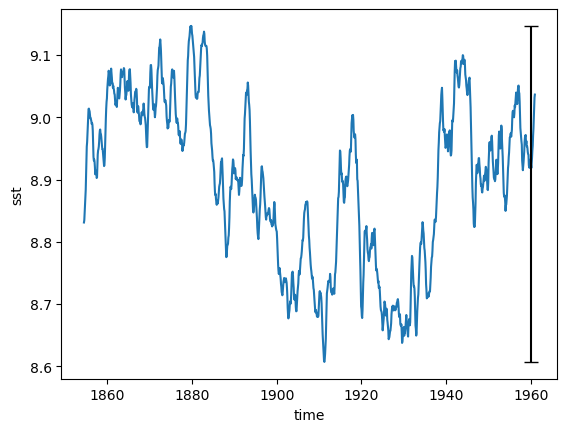

In [9]:
obs_sosst_12mrm_pre1960.plot()
plt.errorbar(sst_obs.sel(time=('1960-01')).time.values, (obs_sst_max + obs_sst_min)/2, (obs_sst_max - obs_sst_min)/2, capsize=5, color='k')

<ErrorbarContainer object of 3 artists>

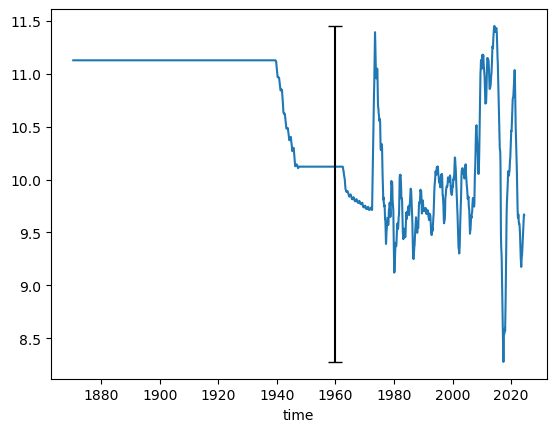

In [10]:
obs_aasie_12mrm.plot()
plt.errorbar(sst_obs.sel(time=('1960-01')).time.values, (obs_sie_max + obs_sie_min)/2, (obs_sie_max - obs_sie_min)/2, capsize=5, color='k')

In [11]:
hr_sst = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-SOSST-full.nc')
lr_sst = xr.open_dataset('/roselab_rit/rford/iHESP-data/LRCESM-SOSST-full.nc').sel(time=slice('0150', None)) # There is significant spinup before 150

hr_sie = xr.open_dataset('/roselab_rit/rford/iHESP-data/HRCESM-AASIE-full.nc')
lr_sie = xr.open_dataset('/roselab_rit/rford/iHESP-data/LRCESM-AASIE-full.nc').sel(time=slice('0150', None))

In [12]:
hr_sosst = detrend_dim(hr_sst.TEMP, dim='time')
lr_sosst = detrend_dim(lr_sst.TEMP, dim='time')

# /1e12 converts from m^2 to 10^6 km^2
hr_aasie = detrend_dim(hr_sie.tarea/1e12, dim='time')
lr_aasie = detrend_dim(lr_sie.tarea/1e12, dim='time')

In [13]:
hr_sossta = detrend_dim(deseasonalize(hr_sst.TEMP), dim='time')
lr_sossta = detrend_dim(deseasonalize(lr_sst.TEMP), dim='time')

# /1e12 converts from m^2 to 10^6 km^2
hr_aasiea = detrend_dim(deseasonalize(hr_sie.tarea)/1e12, dim='time')
lr_aasiea = detrend_dim(deseasonalize(lr_sie.tarea)/1e12, dim='time')

In [14]:
hr_sossta

<xarray.DataArray (time: 4440)> Size: 36kB
array([-0.23992436, -0.14578179, -0.1043313 , ..., -0.07685115,
       -0.08353059, -0.08406962], shape=(4440,))
Coordinates:
  * time     (time) object 36kB 0150-02-01 00:00:00 ... 0520-01-01 00:00:00
    z_t      (time) float32 18kB 500.0 500.0 500.0 500.0 ... 500.0 500.0 500.0
    month    (time) int64 36kB 2 3 4 5 6 7 8 9 10 11 ... 4 5 6 7 8 9 10 11 12 1

In [15]:
hr_sossta_mc_spectrum = ar1_mc_percentiles(hr_sossta.values)
lr_sossta_mc_spectrum = ar1_mc_percentiles(lr_sossta.values)

hr_aasiea_mc_spectrum = ar1_mc_percentiles(hr_aasiea.values)
lr_aasiea_mc_spectrum = ar1_mc_percentiles(lr_aasiea.values)

In [16]:
hr_sossta_freq, hr_sossta_spec = periodogram(hr_sossta.values, fs=12)
lr_sossta_freq, lr_sossta_spec = periodogram(lr_sossta.values, fs=12)
# hr_sossta_spec /= 12 # To get units V^2*month to V^2*year
# lr_sossta_spec /= 12

hr_aasiea_freq, hr_aasiea_spec = periodogram(hr_aasiea.values, fs=12)
lr_aasiea_freq, lr_aasiea_spec = periodogram(lr_aasiea.values, fs=12)
# hr_aasiea_spec /= 12
# lr_aasiea_spec /= 12

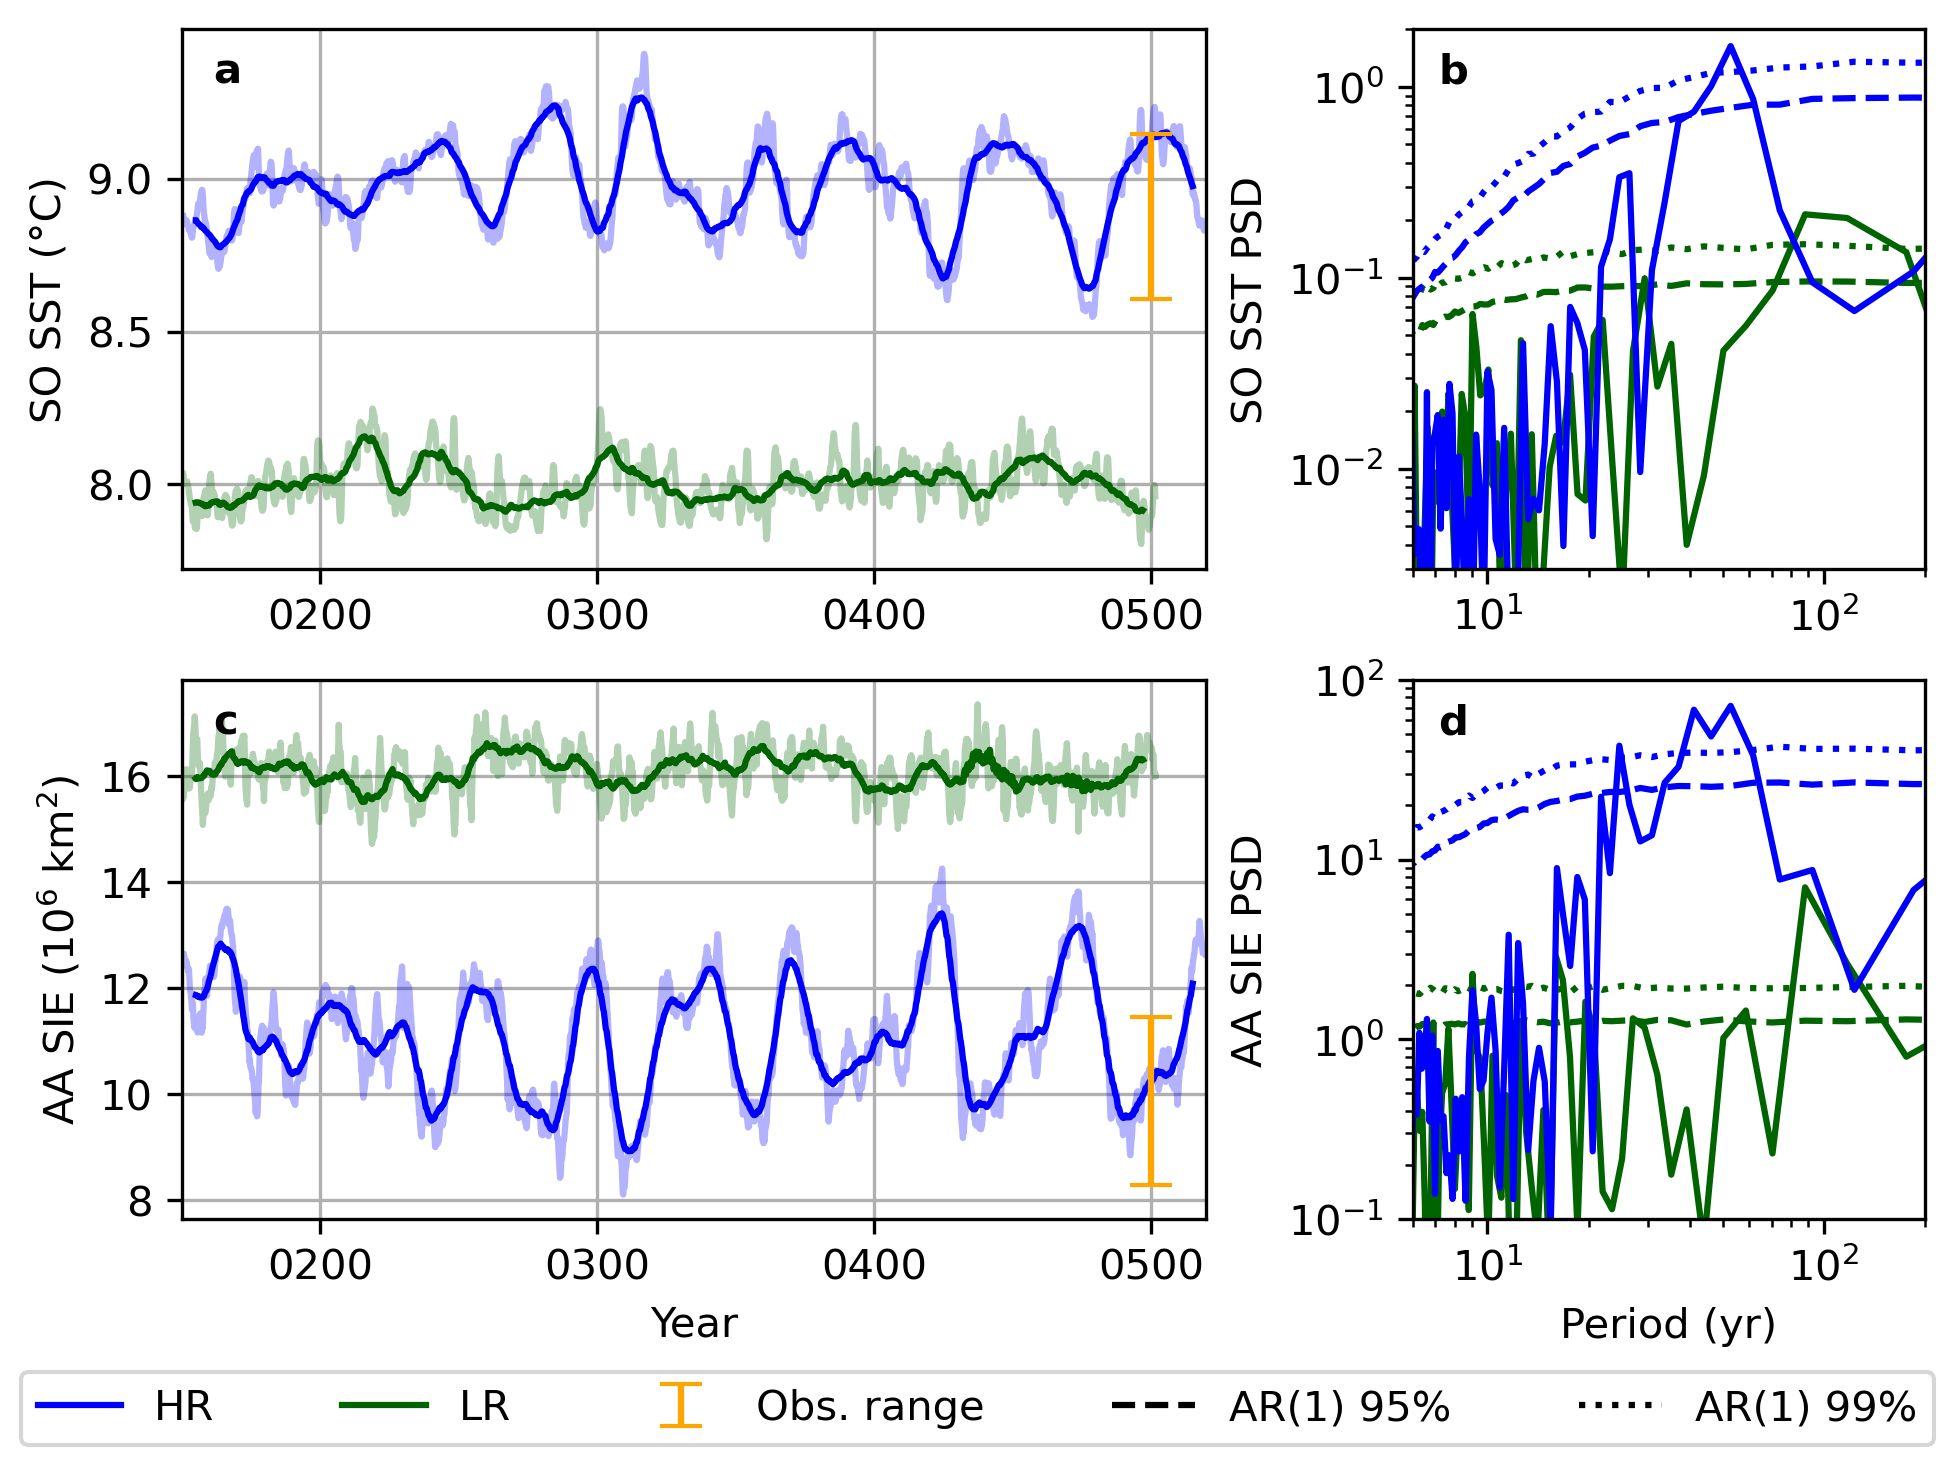

In [17]:
fig1 = plt.figure(1, dpi=300, constrained_layout=True)
axdict = fig1.subplot_mosaic(
    '''
    AAB
    CCD
    '''
)

# Anomaly plots
# axdict['A'].plot(lr_sossta.time, lr_sossta, color='darkgreen', alpha=0.3)
# axdict['A'].plot(lr_sossta.time, rolling_mean(lr_sossta), color='darkgreen')
# axdict['A'].plot(hr_sossta.time, hr_sossta, color='blue', alpha=0.3)
# axdict['A'].plot(hr_sossta.time, rolling_mean(hr_sossta), color='blue')
# axdict['A'].set_xlim(hr_sossta.time.min().values, hr_sossta.time.max().values)
# axdict['A'].set_ylabel('SO SST anomaly (°C)')
# axdict['A'].axhline(0, linestyle='-', color='k', alpha=0.5, zorder=-1)
# axdict['A'].set_ylim(-0.6, 0.6)

# axdict['C'].plot(lr_aasiea.time, lr_aasiea, color='darkgreen', alpha=0.3)
# axdict['C'].plot(lr_aasiea.time, rolling_mean(lr_aasiea), color='darkgreen')
# axdict['C'].plot(hr_aasiea.time, hr_aasiea, color='blue', alpha=0.3)
# axdict['C'].plot(hr_aasiea.time, rolling_mean(hr_aasiea), color='blue')
# axdict['C'].set_xlim(hr_aasiea.time.min().values, hr_aasiea.time.max().values)
# axdict['C'].set_xlabel('Year')
# axdict['C'].set_ylabel('AA SIE anomaly (10$^6$ km$^2$)')
# axdict['C'].axhline(0, linestyle='-', color='k', alpha=0.5, zorder=-1)
# axdict['C'].set_ylim(-4, 4)
# axdict['C'].set_yticks([-4, -2, 0, 2, 4], ['$-$4.0', '$-$2.0', '0.0', '2.0', '4.0'])

axdict['A'].plot(lr_sosst.time, rolling_mean(lr_sosst, t=12), color='darkgreen', alpha=0.3)
axdict['A'].plot(lr_sosst.time, rolling_mean(lr_sosst), color='darkgreen')
axdict['A'].plot(hr_sosst.time, rolling_mean(hr_sosst, t=12), color='blue', alpha=0.3)
axdict['A'].plot(hr_sosst.time, rolling_mean(hr_sosst), color='blue')
axdict['A'].set_xlim(hr_sosst.time.min().values, hr_sosst.time.max().values)
axdict['A'].set_ylabel('SO SST (°C)')
axdict['A'].grid()
# axdict['A'].axhline(0, linestyle='-', color='k', alpha=0.5, zorder=-1)
# axdict['A'].set_ylim(-0.6, 0.6)
obs_err = axdict['A'].errorbar(hr_aasie.sel(time=('0500-01')).time.values, (obs_sst_max + obs_sst_min)/2, (obs_sst_max - obs_sst_min)/2, capsize=5, color='orange', fmt='none')

axdict['C'].plot(lr_aasiea.time, rolling_mean(lr_aasie, t=12), color='darkgreen', alpha=0.3)
axdict['C'].plot(lr_aasiea.time, rolling_mean(lr_aasie), color='darkgreen')
axdict['C'].plot(hr_aasiea.time, rolling_mean(hr_aasie, t=12), color='blue', alpha=0.3)
axdict['C'].plot(hr_aasiea.time, rolling_mean(hr_aasie), color='blue')
axdict['C'].set_xlim(hr_aasie.time.min().values, hr_aasie.time.max().values)
axdict['C'].set_xlabel('Year')
axdict['C'].set_ylabel('AA SIE (10$^6$ km$^2$)')
axdict['C'].grid()
# axdict['C'].axhline(0, linestyle='-', color='k', alpha=0.5, zorder=-1)
# axdict['C'].set_ylim(-4, 4)
# axdict['C'].set_yticks([-4, -2, 0, 2, 4], ['$-$4.0', '$-$2.0', '0.0', '2.0', '4.0'])
axdict['C'].errorbar(hr_aasie.sel(time=('0500-01')).time.values, (obs_sie_max + obs_sie_min)/2, (obs_sie_max - obs_sie_min)/2, capsize=5, color='orange')

axdict['B'].plot(1/lr_sossta_mc_spectrum['freq'], lr_sossta_mc_spectrum['99'], color='darkgreen', linestyle=':')
axdict['B'].plot(1/lr_sossta_mc_spectrum['freq'], lr_sossta_mc_spectrum['95'], color='darkgreen', linestyle='--')
axdict['B'].plot(1/lr_sossta_freq, lr_sossta_spec, color='darkgreen')
# axdict['B'].fill_between(1/lr_sossta_freq[:, 0], lr_sst_spec_ci[:, 0], lr_sst_spec_ci[:, 1], color='darkgreen', alpha=0.3)
axdict['B'].plot(1/hr_sossta_mc_spectrum['freq'], hr_sossta_mc_spectrum['99'], color='blue', linestyle=':')
axdict['B'].plot(1/hr_sossta_mc_spectrum['freq'], hr_sossta_mc_spectrum['95'], color='blue', linestyle='--')
axdict['B'].plot(1/hr_sossta_freq, hr_sossta_spec, color='blue')
# axdict['B'].fill_between(1/hr_sossta_freq[:, 0], hr_sst_spec_ci[:, 0], hr_sst_spec_ci[:, 1], color='blue', alpha=0.3)
axdict['B'].set_xscale('log')
axdict['B'].set_yscale('log')
axdict['B'].set_ylabel('SO SST PSD')
axdict['B'].set_xlim(6, 200)
axdict['B'].set_ylim(3e-3, 2e0)
# axdict['B'].axvspan(40, 60, color='k', alpha=0.25)

axdict['D'].plot(1/lr_aasiea_mc_spectrum['freq'], lr_aasiea_mc_spectrum['99'], label='LR AR(1) 99%', color='darkgreen', linestyle=':')
axdict['D'].plot(1/lr_aasiea_mc_spectrum['freq'], lr_aasiea_mc_spectrum['95'], label='LR AR(1) 95%', color='darkgreen', linestyle='--')
axdict['D'].plot(1/lr_aasiea_freq, lr_aasiea_spec, label='LR', color='darkgreen')
# axdict['D'].fill_between(1/lr_aasiea_freq[:, 0], lr_sie_spec_ci[:, 0], lr_sie_spec_ci[:, 1], color='darkgreen', alpha=0.3)
axdict['D'].plot(1/hr_aasiea_mc_spectrum['freq'], hr_aasiea_mc_spectrum['99'], label='AR(1) 99%', color='blue', linestyle=':')
axdict['D'].plot(1/hr_aasiea_mc_spectrum['freq'], hr_aasiea_mc_spectrum['95'], label='AR(1) 95%', color='blue', linestyle='--')
axdict['D'].plot(1/hr_aasiea_freq, hr_aasiea_spec, label='HR', color='blue')
# axdict['D'].fill_between(1/hr_aasiea_freq[:, 0], hr_sie_spec_ci[:, 0], hr_sie_spec_ci[:, 1], color='blue', alpha=0.3)
axdict['D'].set_xscale('log')
axdict['D'].set_yscale('log')
axdict['D'].set_xlabel('Period (yr)')
axdict['D'].set_ylabel('AA SIE PSD')
axdict['D'].set_xlim(6, 200)
axdict['D'].set_ylim(1e-1, 1e2)
# axdict['D'].axvspan(40, 60, color='k', alpha=0.25)

axdict['A'].annotate('a', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
axdict['B'].annotate('b', xy=(0.05, 0.9), xycoords='axes fraction', fontweight='bold')
axdict['C'].annotate('c', xy=(0.03, 0.9), xycoords='axes fraction', fontweight='bold')
axdict['D'].annotate('d', xy=(0.05, 0.9), xycoords='axes fraction', fontweight='bold')

legend_lines = [Line2D([0], [0], color='blue'),
                Line2D([0], [0], color='darkgreen'),
                obs_err,
                Line2D([0], [0], color='k', linestyle='--'),
                Line2D([0], [0], color='k', linestyle=':')]
fig1.legend(legend_lines, ['HR', 'LR', 'Obs. range', 'AR(1) 95%', 'AR(1) 99%'], loc='outside lower center', mode='expand', ncols=5)

In [18]:
# fig1.savefig('ts-spec.pdf')

In [19]:
import pkg_resources

packages = pkg_resources.working_set
for p in packages:
    print(p.key, p.version)

/tmp/ipykernel_8876/4016747970.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


cerberus 1.3.5
deprecated 1.2.18
flask-caching 2.3.1
heapdict 1.0.1
pycrs 1.0.2
pyjwt 2.10.1
pyside6 6.9.3
pysocks 1.7.1
send2trash 1.8.3
webob 1.8.9
act-atmos 2.2.3
affine 2.4.0
aiobotocore 2.25.0
aiohappyeyeballs 2.6.1
aiohttp 3.13.0
aioitertools 0.12.0
aiosignal 1.4.0
alabaster 0.7.16
altair 5.5.0
aniso8601 10.0.0
annotated-types 0.7.0
antimeridian 0.4.3
anyio 4.11.0
anywidget 0.9.18
app-model 0.4.0
appdirs 1.4.4
archspec 0.2.5
argon2-cffi 25.1.0
argon2-cffi-bindings 25.1.0
arm-pyart 2.1.1
arm-test-data 0.1.2
arro3-compute 0.6.5
arro3-core 0.6.5
arro3-io 0.6.5
arrow 1.4.0
asf-search 10.1.2
astropy 7.1.1
astropy-iers-data 0.2025.10.20.0.39.8
asttokens 3.0.0
async-lru 2.0.5
async-timeout 5.0.1
asyncssh 2.21.1
attrs 25.4.0
autopage 0.5.2
awscli 2.31.21
awscrt 0.27.6
babel 2.17.0
beautifulsoup4 4.14.2
bermuda 0.1.6
black 25.1.0
bleach 6.2.0
blinker 1.9.0
bokeh 3.8.0
bokeh-sampledata 2025.0
boltons 25.0.0
boto3 1.40.49
botocore 1.40.49
bottleneck 1.6.0
bqplot 0.12.45
branca 0.8.2
brotli 